In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. 读取数据和预处理
df = pd.read_csv('country_inter_gen.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(), inplace=True)
# 如果最后一行存在部分缺失，可考虑删除：
df = df.iloc[:-1, :]
df.head()

,A GDP,A Unemployment Rate,A Inflation Rate,A Foreign Debt,A Government Spending,A Military Spending,A Education Spending,A Health Spending,A Environment Spending,A Technology Investment,...,A Technology I,A Health I,B Political I,B Economic I,B Military I,B Diplomatic I,B Social I,B Environmental I,B Technology I,B Health I
0,14514.82,5.73,1.48,307.68,805.93,168.13,72.87,144.91,47.90,240.33,...,0,0,0,0,0,0,0,0,0,0
1,14463.09,5.52,-0.09,305.26,830.80,179.34,73.46,166.45,79.18,242.91,...,1,1,1,2,5,3,2,2,1,1
2,14225.03,5.07,-1.70,298.20,804.90,189.87,73.80,187.53,111.35,245.87,...,1,1,1,2,5,3,2,2,2,1
3,13776.89,4.42,-3.22,287.25,806.75,200.04,75.38,207.06,142.73,245.29,...,1,1,1,2,5,3,2,2,2,1
4,13483.10,3.56,-4.85,282.04,791.58,214.47,73.20,230.93,174.44,247.76,...,1,1,1,2,5,3,2,2,2,1


XGBoost Multi-Output - Test Mean Squared Error: 0.13997252081459188
XGBoost Multi-Output - Test R² Score: 0.3915366139229264
XGBoost Multi-Output - Test Mean Absolute Error: 0.047791363170331294
XGBoost Multi-Output - Test Explained Variance: 0.3975818196301033


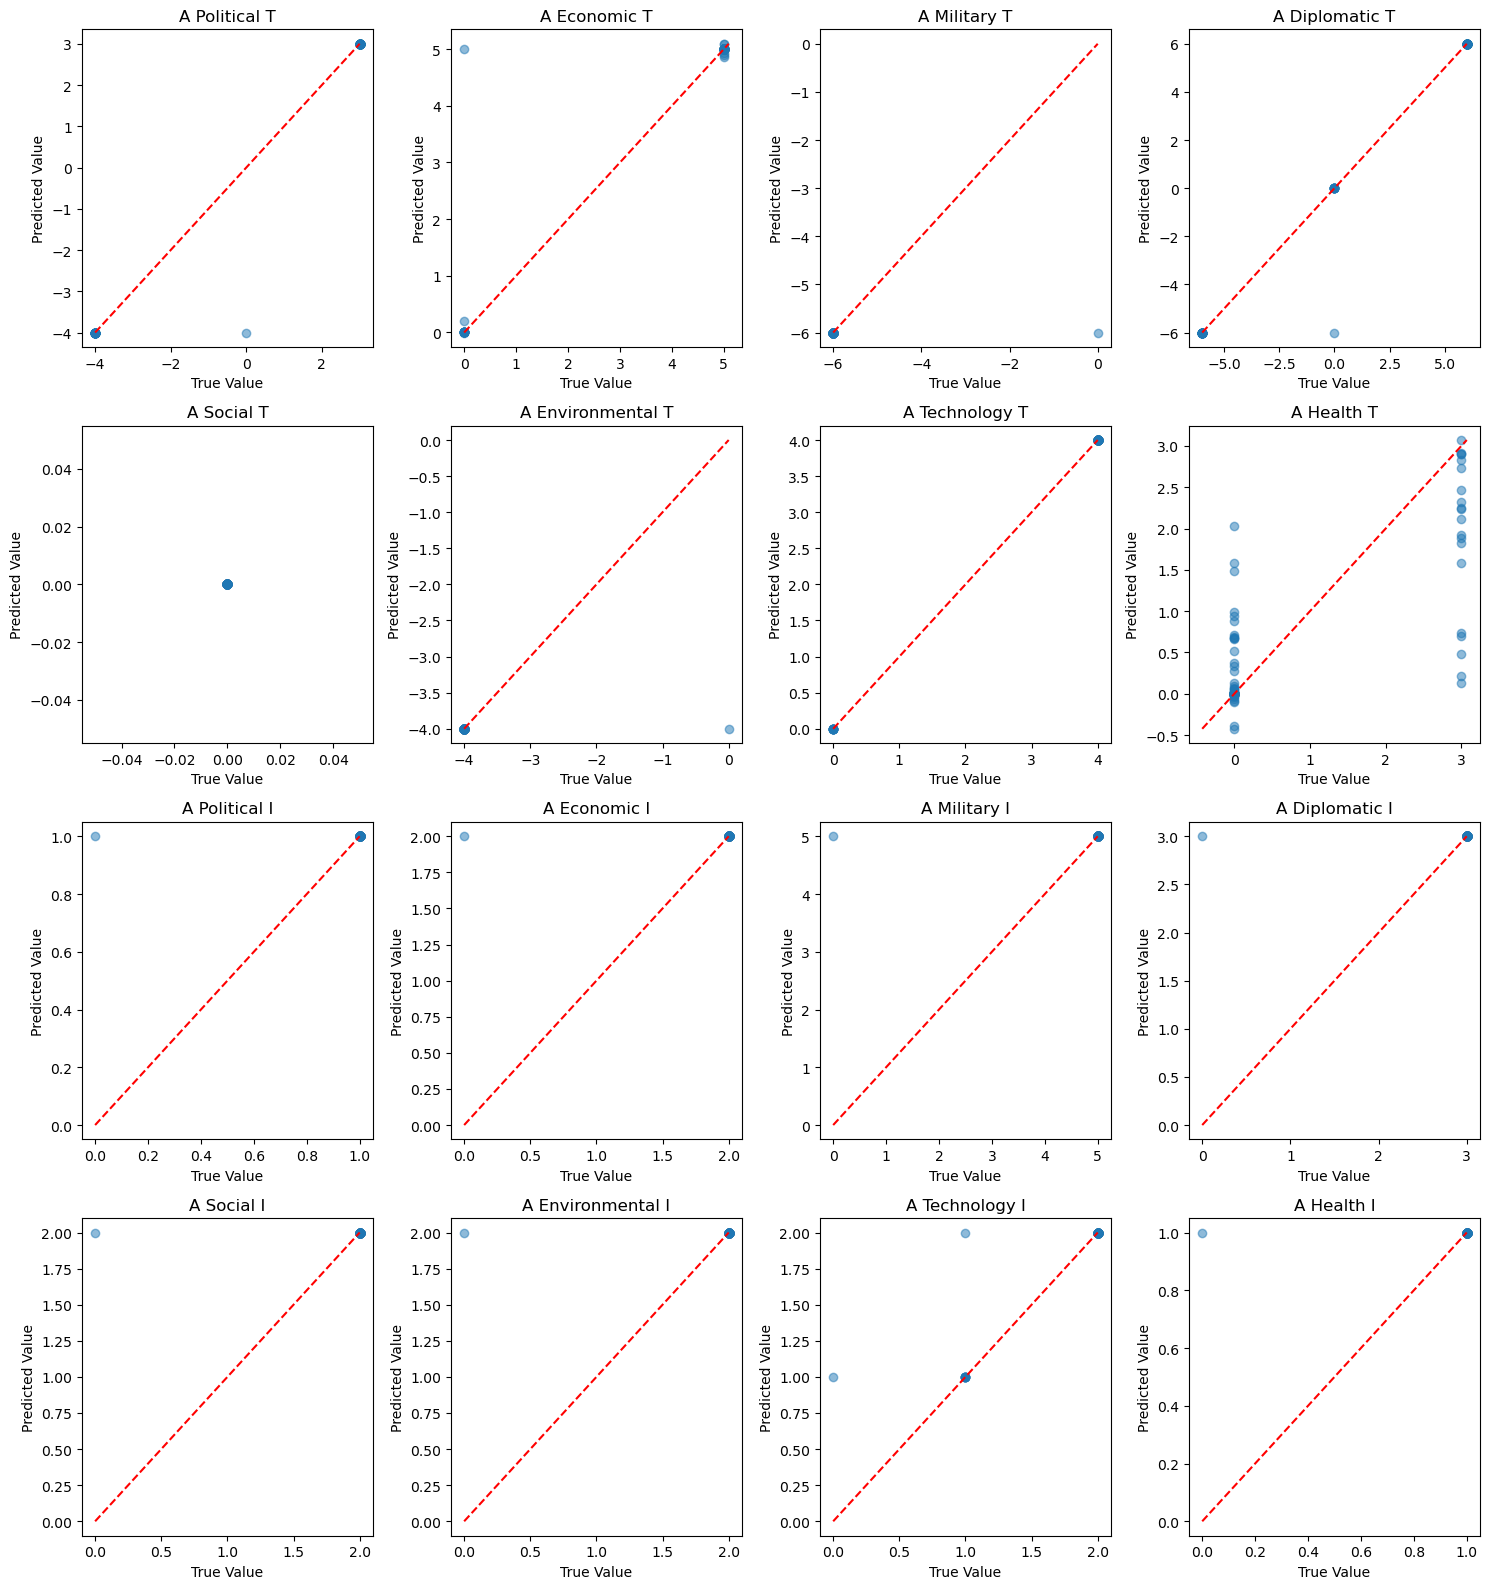

In [2]:
# 2. 定义特征和目标变量
target_columns = [
    'A Political T', 'A Economic T', 'A Military T', 'A Diplomatic T',
    'A Social T', 'A Environmental T', 'A Technology T', 'A Health T',
    'A Political I', 'A Economic I', 'A Military I', 'A Diplomatic I',
    'A Social I', 'A Environmental I', 'A Technology I', 'A Health I'
]
X = df.drop(columns=target_columns)
y = df[target_columns]

# 3. 特征标准化：调整特征的尺度，通常有助于提高模型稳定性
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 划分训练集与测试集（这里可采用交叉验证，暂时先进行独立划分用于后续评估）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. 构建多目标回归 XGBoost 模型：使用 MultiOutputRegressor 封装 XGBRegressor
# 指定目标函数为 reg:squarederror，常用于回归问题
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
multi_target_model = MultiOutputRegressor(xgb_regressor)

# 6. 模型训练
multi_target_model.fit(X_train, y_train)

# 7. 模型预测与评估（单个测试集评估示例）
y_pred = multi_target_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
ev = explained_variance_score(y_test, y_pred, multioutput='uniform_average')

print("XGBoost Multi-Output - Test Mean Squared Error:", mse)
print("XGBoost Multi-Output - Test R² Score:", r2)
print("XGBoost Multi-Output - Test Mean Absolute Error:", mae)
print("XGBoost Multi-Output - Test Explained Variance:", ev)

# 8. 可视化：绘制每个目标变量的预测值与真实值散点图
n_targets = len(target_columns)
n_cols = 4  # 每行显示4个子图
n_rows = int(np.ceil(n_targets / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# 将预测结果转换为 DataFrame，便于后续绘图时匹配列名
y_pred_df = pd.DataFrame(y_pred, columns=target_columns)

for i, col in enumerate(target_columns):
    axes[i].scatter(y_test[col], y_pred_df[col], alpha=0.5)
    axes[i].set_title(col)
    axes[i].set_xlabel("True Value")
    axes[i].set_ylabel("Predicted Value")
    # 绘制 y=x 参考线，帮助对比预测结果与真实值
    min_val = min(y_test[col].min(), y_pred_df[col].min())
    max_val = max(y_test[col].max(), y_pred_df[col].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')

# 删除超出实际目标数的子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()
